# Helper functions

In [29]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import re
from SynFlow.SCD import print_jsd_by_period, plot_jsd_by_period, plot_items_jsd_by_period

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Merge into multi-word phrase

In [ ]:
def merge_phrases(head_lemma, dep_lemma, file_path):
    pattern = re.compile(
        r'^([^\t]+)\t'      # wordform
        r'([^\t]+)\t'       # lemma
        r'([^\t]+)\t'       # POS
        r'([^\t]+)\t'       # ID
        r'([^\t]+)\t'       # HEAD
        r'([^\t]+)$'        # DEPREL
    )

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    new_lines = []
    sentence = []
    in_sentence = False

    for line in lines:
        stripped = line.strip()
        if stripped.startswith('<s id='):
            sentence = [line]
            in_sentence = True
        elif stripped.startswith('</s>'):
            sentence.append(line)

            # Tách các dòng chứa token
            tokens = [l.strip() for l in sentence if pattern.match(l)] # Get the line with the tokens
            parsed = [pattern.match(l).groups() for l in tokens] # A list of tuples of individual tokens
            # print(parsed)
            id2token = {fields[3]: list(fields) for fields in parsed}  # A dictonary idx: [wordform, lemma, pos, id, head, deprel]
            # print(id2token)
            merged_heads = set() # Avoid merging multiple times with one head

            for fields in parsed:
                wordform, lemma, pos, idx, head, deprel = fields # Tuple unpacking
                # Nếu đúng là dep lemma, và head tồn tại
                if lemma == dep_lemma and head in id2token:
                    print(head)
                    head_fields = id2token[head]
                    print(head_fields)
                    head_wordform, head_lemma_ = head_fields[0], head_fields[1],
                    if head_lemma_.lower() == head_lemma.lower() and head not in merged_heads:
                        # Gộp lại
                        merged_lemma = f"{dep_lemma}_{head_lemma_}"
                        merged_token = f"{dep_lemma}_{head_wordform}"
                        id2token[head][0] = merged_token
                        id2token[head][1] = merged_lemma
                        merged_heads.add(head)

            # Ghi lại câu đã cập nhật
            updated_sentence = []
            for l in sentence:
                m = pattern.match(l.strip())
                if not m:
                    updated_sentence.append(l)
                    continue
                wordform, lemma, pos, idx, head, deprel = m.groups()
                if idx in id2token:
                    wordform, lemma, _, _, _, _ = id2token[idx]
                updated_sentence.append(f"{wordform}\t{lemma}\t{pos}\t{idx}\t{head}\t{deprel}\n")
            new_lines.extend(updated_sentence)
            in_sentence = False
        elif in_sentence:
            sentence.append(line)
        else:
            new_lines.append(line)

    with open(file_path, 'w', encoding='utf-8') as f:
        f.writelines(new_lines)


In [ ]:
for file in os.listdir("/home/volt/bach/pilot_data/RSC/1750-1800-che"):
    file_path = "/home/volt/bach/pilot_data/RSC/1750-1800-che/" + file
    print(file_path)
    merge_phrases(head_lemma="air", dep_lemma="dephlogisticate", file_path=file_path)

# Merged Phrases:
# phlogisticated air
# dephlogisticated air

In [ ]:
folder = "/home/volt/bach/pilot_data/RSC/1750-1800_che"

for file in os.listdir(folder):
    file_path = os.path.join(folder, file)

    # Đảm bảo là file văn bản, nếu cần
    if not os.path.isfile(file_path):
        continue

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Thay thế các cụm từ
    content = content.replace("phlogisticated_air", "air")

    # Ghi đè lại
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)

    print(f"✓ Done: {file_path}")

# Analysis

In [30]:
# RSC
target_lemma = 'air'
target_pos = 'N'
keyword_string = f'{target_lemma}\t{target_pos}' # Or you can use the full POS for precision (e.g., {target_lemma}\tNOUN)
period = '1750-1819'
corpus_path = '/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades'
fname_pattern = re.compile(
    r'Royal_Society_Corpus_open_v6\.0_text_(?P<id>\d+)_(?P<year>\d+)\.txt$'
)
input_SCD = f'/home/volt/bach/SynFlow/input/SCD/{target_lemma}-{target_pos}-{period}'
os.makedirs(input_SCD, exist_ok=True)

# # COHA
# corpus_path = '/home/volt/bach/pilot_data/COHA'
# fname_pattern = re.compile(
#     r'^(?P<genre>[A-Za-z]+)_(?P<year>\d{4})_(?P<id>\d+)\.txt$'
# )

### Air
1. See the shift in the distribution of the adjective that comes with air
2. Merge phlogisticated and dephlogisticated with air
    * See the shift in the distribution of phlogistcated air and dephlogisticated air
    * Compare that with the distribution of oxygen and nitrogen

In [39]:
fname_df_pattern = re.compile(
    rf'air/Royal_Society_Corpus_open_v6\.0_text_'   # fixed prefix
    rf'(?P<id>\d+)_'                            # capture numeric ID
    rf'(?P<year>\d+)'                           # capture year
    rf'.txt/\d+$'             #  and extension and line number
)

#### Preprocessing

This step is unique to the type of data we're working with.

In [51]:
from SynFlow.Explorer import replace_in_sfiller_df_column

air_chiamod_df_path = f'{input_SCD}/air_chiamod_1750-1819.csv'

replacements = {
    "dephlogisticate/V": "dephlogisticated/A",
    "phlogisticate/V": "phlogisticated/A",
    'plllogisticate/V': 'phlogisticated/A',
    'deplllogisticate/V': 'dephlogisticated/A',
    'gisticate/V': 'phlogisticated/A',
    'Open/A': 'open/A',
    'atmospheric/A': 'atmospherical/A',
}

replace_in_sfiller_df_column('/home/volt/bach/SynFlow/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_all.csv',
                             'chi_amod',
                             replacements=replacements,
                             output_path = air_chiamod_df_path)


In [ ]:
# Filter by minimum frequency

from SynFlow.Explorer.sfiller_df import filter_frequency_sfiller
filter_frequency_sfiller(air_chiamod_df_path, 'chi_amod', 1)

#### Frequency Changes

In [64]:
from SynFlow.SCD.freq import plot_freq_top_union_sfillers_by_period
slot_type = 'chi_amod'
slot_df_path = air_chiamod_df_path
print(slot_df_path)

/home/volt/bach/SynFlow/input/SCD/air-N-1750-1819/air_chiamod_1750-1819.csv


In [69]:
# Bar chart (absolute freq)
plot_freq_top_union_sfillers_by_period(slot_df_path, 
                              slot_type=slot_type,
                              top_n=10,
                              normalized=True, # Normalised or Raw count
                              time_col='subfolder',
                              )

#### Slot Filler JSD

In [70]:
from SynFlow.SCD.jsd import sfillers_jsd_by_period

In [72]:
sfillers_js_df = pd.read_csv(slot_df_path)
sfillers_js_results = sfillers_jsd_by_period(sfillers_js_df, word_col=slot_type, period_col='subfolder')
print_jsd_by_period(sfillers_js_results)


=== Shift to period 1755 ===
Jensen-Shannon Divergence: 0.5817
Top shifted items:
  de_open/A: 0.1200
  in_fresh/A: 0.0479
  de_dry/A: 0.0294
  in_incumbent/A: 0.0205
  in_common/A: 0.0205
  in_subjacent/A: 0.0205
  de_pure/A: 0.0196
  in_low/A: 0.0137
  in_hot/A: 0.0137
  in_confine/V: 0.0137

=== Shift to period 1760 ===
Jensen-Shannon Divergence: 0.5762
Top shifted items:
  de_fresh/A: 0.0479
  in_moist/A: 0.0385
  in_surround/V: 0.0385
  in_open/A: 0.0381
  in_hot/A: 0.0210
  de_subjacent/A: 0.0205
  de_incumbent/A: 0.0205
  de_common/A: 0.0205
  in_dry/A: 0.0192
  in_more/A: 0.0192

=== Shift to period 1765 ===
Jensen-Shannon Divergence: 0.7917
Top shifted items:
  in_fix/V: 0.1603
  de_open/A: 0.1271
  in_common/A: 0.0870
  in_inflammable/A: 0.0605
  de_hot/A: 0.0511
  de_surround/V: 0.0385
  de_moist/A: 0.0325
  de_rarefied/A: 0.0286
  in_much/A: 0.0234
  de_heat/V: 0.0192

=== Shift to period 1770 ===
Jensen-Shannon Divergence: 0.2665
Top shifted items:
  in_nitrous/A: 0.0601


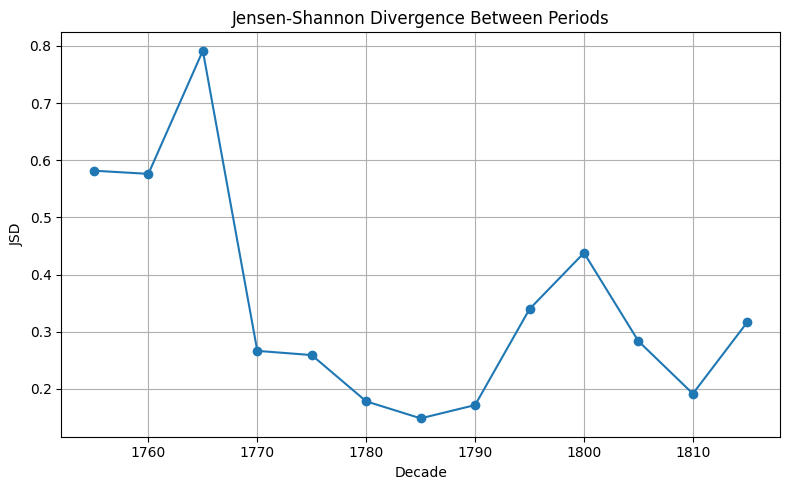

In [73]:
plot_jsd_by_period(sfillers_js_results)

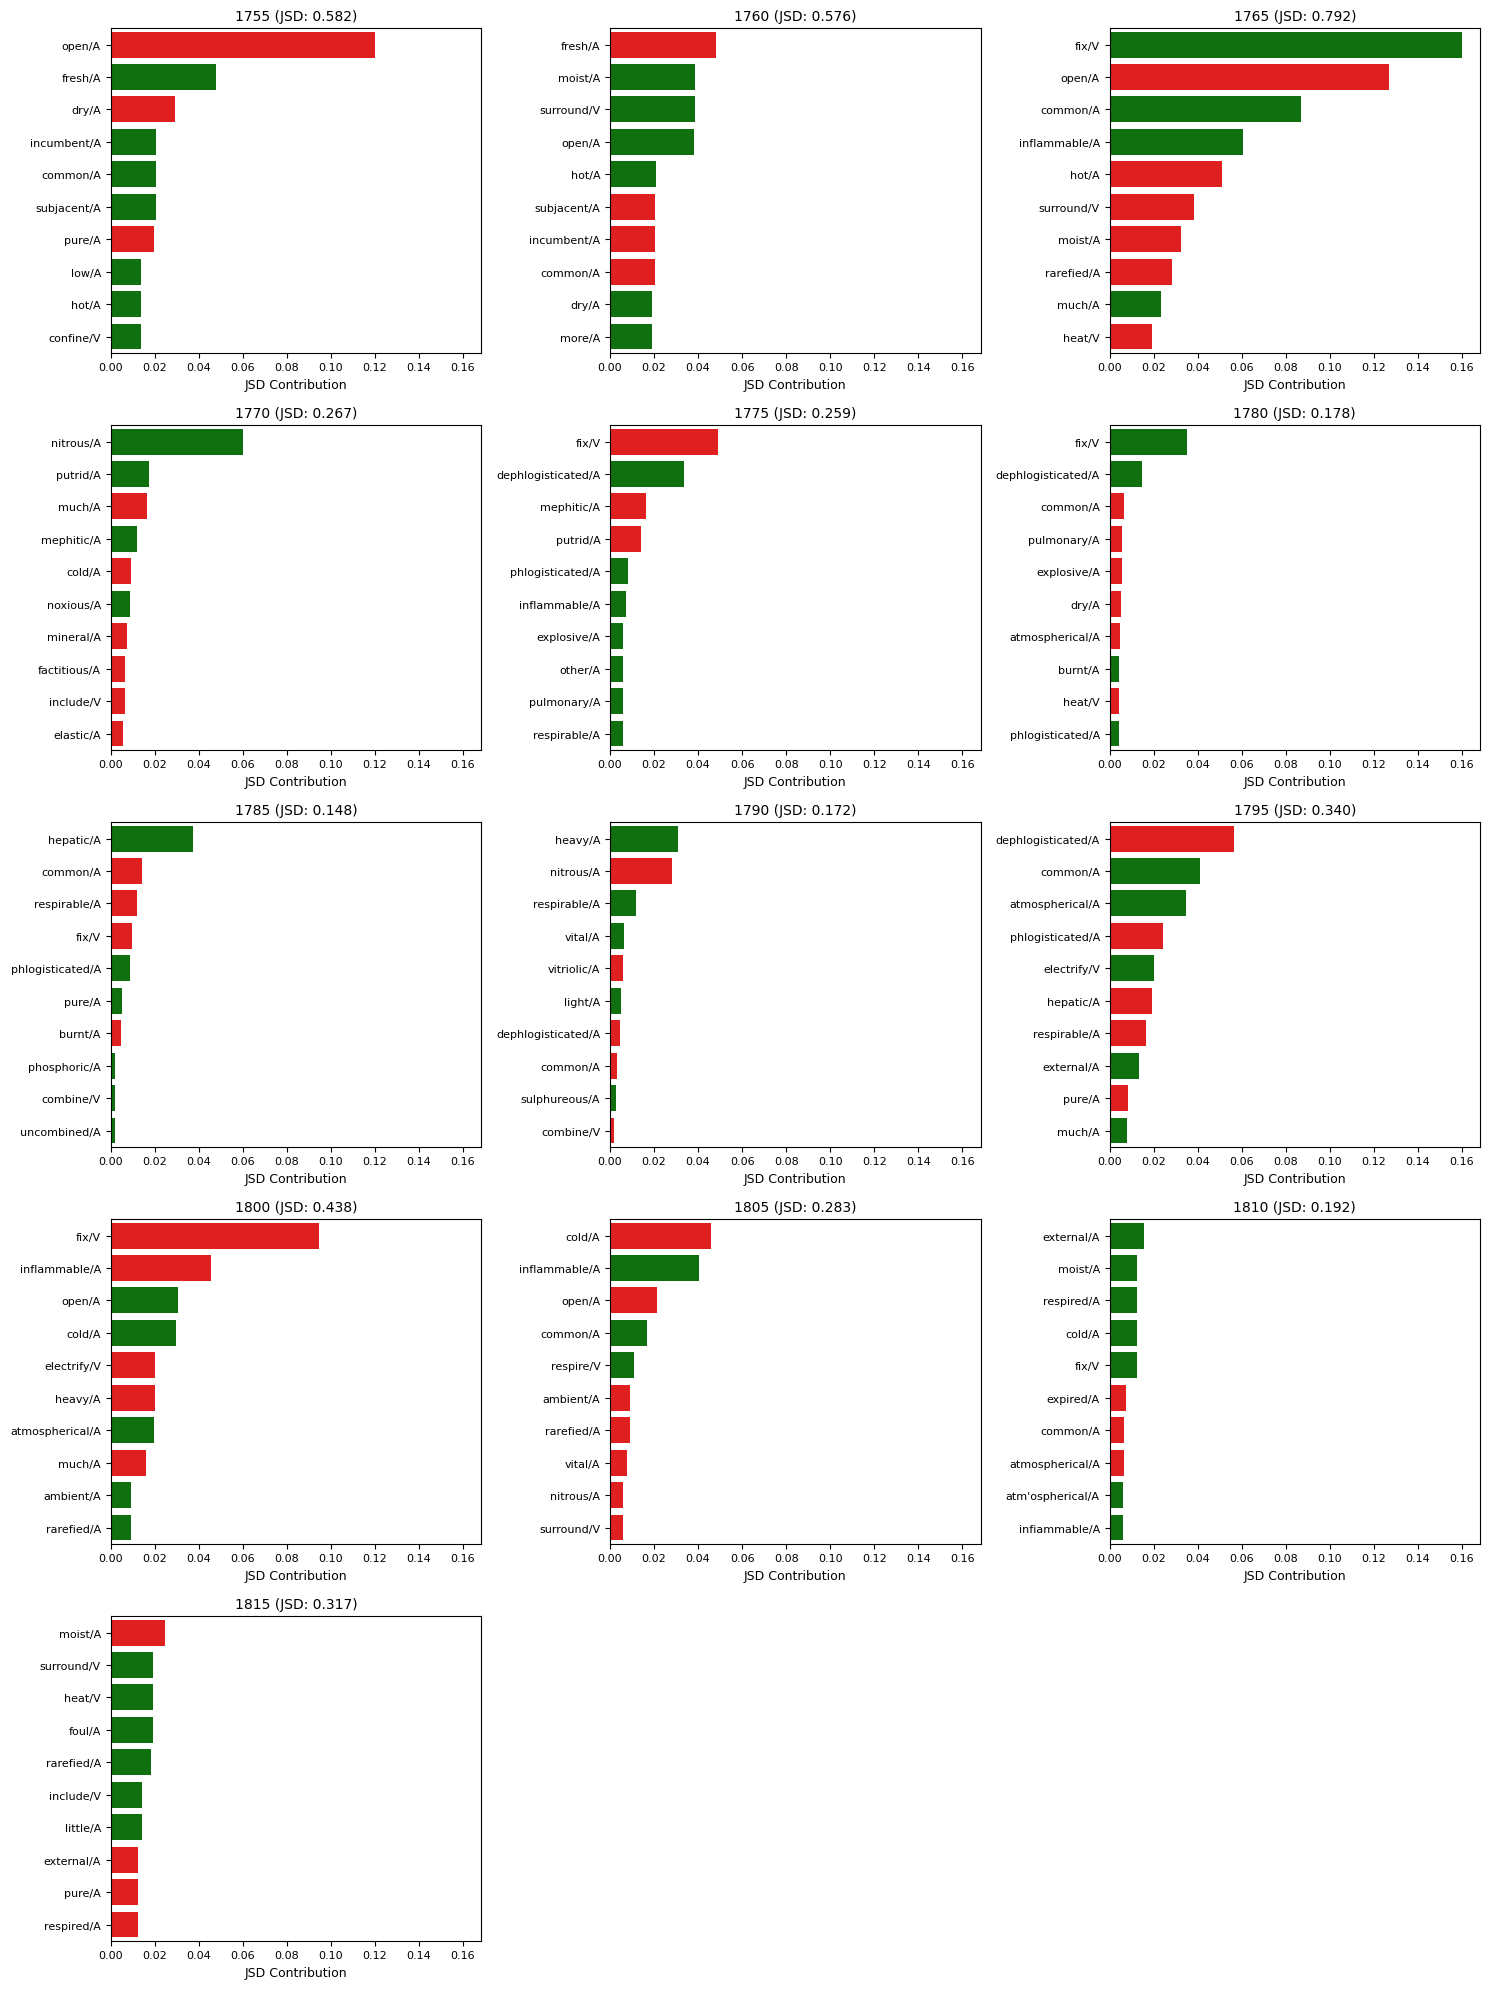

In [74]:
plot_items_jsd_by_period(sfillers_js_results, top_n=10, cols=3)

### Part

In [ ]:
fname_df_pattern = re.compile(
    rf'air/Royal_Society_Corpus_open_v6\.0_text_'   # fixed prefix
    rf'(?P<id>\d+)_'                            # capture numeric ID
    rf'(?P<year>\d+)'                           # capture year
    rf'.txt/\d+$'             #  and extension and line number
)

#### Preprocessing

In [ ]:
# Process the adjective dataframe
def process_part_slot_csv(slot_type, input_path, output_path):
    """
    Process a CSV file to:
    - Unpack list values in 'slot_type' column into separate rows
    - Extract year from 'id' column using regex
    - Compute 'decade' (e.g. 1750, 1760) and 'half_decade' (e.g. 1750–1754, 1755–1759)
    - Only keep rows from 1750–1799
    - Write the cleaned result to a new CSV
    """

    # Read CSV
    df = pd.read_csv(input_path)

    # Ensure slot_type is a list (assumes it's stored as a string representation)
    df[slot_type] = df[slot_type].apply(eval)

    # Explode lists into separate rows
    df = df.explode(slot_type).reset_index(drop=True)

    # Compile regex to extract year
    pattern = re.compile(
        r'experiment/Royal_Society_Corpus_open_v6\.0_text_'
        r'(?P<id>\d+)_'
        r'(?P<year>\d+)\.txt/\d+$'
    )

    # Extract year, decade, half-decade
    def extract_time_info(id_string):
        match = pattern.match(id_string)
        if match:
            year = int(match.group("year"))
            if 1750 <= year <= 1819:
                decade = year - (year % 10)
                half = f"{year - (year % 5)}–{year - (year % 5) + 4}"
                return pd.Series([year, decade, half])
        return pd.Series([None, None, None])

    df[["year", "decade", "half_decade"]] = df["id"].apply(extract_time_info)
    # Extract start year from half_decade
    df["half_decade"] = df["half_decade"].str.extract(r"(\d{4})").astype(float).astype("Int64")


    # # Drop rows outside 1750–1799
    # df = df[df["decade"].notnull()]

    # Save cleaned file
    df.to_csv(output_path, index=False)

In [ ]:
experiment_chiamod_df = f'{input_SCD}/experiment_chiamod_1750-1819.csv' 

process_part_slot_csv('chi_amod', 
                     '/home/volt/bach/SynFlow/output/experiment-N-1750-1819/Embedding/experiment_samples_sfillerdf_all.csv',
                     experiment_chiamod_df)

In [ ]:
# Filter by minimum frequency
import pandas as pd

def filter_frequency(df_path, min_freq):
    df = pd.read_csv(df_path)
    
    # select 4rd column by position
    col = df.iloc[:, 3]
    
    # filter by frequency
    freq = col.value_counts()
    df = df[col.map(freq) >= min_freq]
    
    # sort by 5th column values (stable sort to preserve original order within groups)
    df = df.sort_values(by=df.columns[4], kind="stable")
    
    # overwrite file
    df.to_csv(df_path, index=False)


filter_frequency(experiment_chiamod_df, 14)

#### Frequency Changes

In [ ]:
from SynFlow.SCD.freq import plot_freq_top_union_sfillers_by_period
slot_type = 'chi_amod'
slot_df = experiment_chiamod_df

In [ ]:
# Bar chart (absolute freq)
plot_freq_top_union_sfillers_by_period(slot_df, 
                              slot_type=slot_type,
                              top_n=10,
                              normalized=True, # Normalised or Raw count
                              time_col='half_decade',
                              )



#### Slot Filler JSD

In [ ]:
from SynFlow.SCD.jsd import sfillers_jsd_by_period

In [ ]:
sfillers_js_df = pd.read_csv(slot_df)
sfillers_js_results = sfillers_jsd_by_period(sfillers_js_df, word_col=slot_type, period_col='half_decade')
print_jsd_by_period(sfillers_js_results)

In [ ]:
plot_jsd_by_period(sfillers_js_results)

In [ ]:
plot_items_jsd_by_period(sfillers_js_results, top_n=10, cols=3)

### Cell

In [ ]:
id_df_pattern = re.compile(
    r'^cell/(?P<genre>[A-Za-z]+)_(?P<year>\d{4})_(?P<id>\d+)\.txt/\d+$'
)

#### Preprocessing

In [ ]:
# Process the adjective dataframe
def process_cell_slot_csv(slot_type, id_df_pattern, input_path, output_path):
    """
    Process a CSV file to:
    - Unpack list values in 'slot_type' column into separate rows
    - Extract year from 'id' column using regex
    - Compute 'decade' (e.g. 1750, 1760) and 'half_decade' (e.g. 1750–1754, 1755–1759)
    - Only keep rows from 1750–1799
    - Write the cleaned result to a new CSV
    """

    # Read CSV
    df = pd.read_csv(input_path)

    # Ensure slot_type is a list (assumes it's stored as a string representation)
    df[slot_type] = df[slot_type].apply(eval)

    # Explode lists into separate rows
    df = df.explode(slot_type).reset_index(drop=True)

    # Extract year, decade, half-decade
    def extract_time_info(id_string):
        match = id_df_pattern.match(id_string)
        if match:
            year = int(match.group("year"))
            if 1900 <= year < 2010:
                decade = year - (year % 10)
                half = f"{year - (year % 5)}–{year - (year % 5) + 4}"
                return pd.Series([year, decade, half])
        return pd.Series([None, None, None])

    df[["year", "decade", "half_decade"]] = df["id"].apply(extract_time_info)
    # Extract start year from half_decade
    df["half_decade"] = df["half_decade"].str.extract(r"(\d{4})").astype(float).astype("Int64")


    # Drop rows outside 1750–1799
    df = df[df["decade"].notnull()]

    # Save cleaned file
    df.to_csv(output_path, index=False)

In [ ]:
cell_chiadj_df = '/home/volt/bach/SynFlow/input/SCD/cell_chiadj_1900-2010.csv'
cell_pacompound_df = '/home/volt/bach/SynFlow/input/SCD/cell_pacompound_1900-2010.csv'
cell_pansubj_df = '/home/volt/bach/SynFlow/input/SCD/cell_pansubj_1900-2010.csv'
cell_chicase_df = '/home/volt/bach/SynFlow/input/SCD/cell_chicase_1900-2010.csv'

# process_cell_slot_csv('chi_case',
#                       id_df_pattern,
#                      '/home/volt/bach/SynFlow/output/cell-N-1900-2000/Embedding/cell_samples_slotdf_all.csv',
#                      cell_chicase_df)

#### Frequency Changes

In [ ]:
from SynFlow.SCD.freq import plot_freq_top_union_sfillers_by_period
slot_type = 'pa_compound'
slot_df = cell_pacompound_df

# slot_type = 'chi_amod'
# slot_df = cell_chiadj_df

# slot_type = 'pa_nsubj'
# slot_df = cell_pansubj_df

# slot_type = 'chi_case'
# slot_df = cell_chicase_df

In [ ]:
# Bar chart (absolute freq)
plot_freq_top_union_sfillers_by_period(slot_df, 
                              slot_type=slot_type,
                              top_n=10,
                              normalized=True, # Normalised or Raw count
                              time_col='decade',
                              chart_type='line' # either line or bar
                              )

#### Slot Filler JSD

In [ ]:
from SynFlow.SCD.jsd import sfillers_jsd_by_period

In [ ]:
sfillers_js_df = pd.read_csv(slot_df)
sfillers_js_results = sfillers_jsd_by_period(sfillers_js_df, word_col=slot_type, period_col='decade')
print_jsd_by_period(sfillers_js_results)

In [ ]:
plot_jsd_by_period(sfillers_js_results)

In [ ]:
plot_items_jsd_by_period(sfillers_js_results, top_n=10, cols=3)
'''
Note: 
The JSD and relative frequency information is very noisy because there are so many infrequent slot fillers (frequency = 1).
Filtering the slot fillers by frequency (>= 5 or 10) will reduce the noise.
Also, clustering the slot fillers then recalculate the JSD will help (see the CELL-ADJ 2d visualisation)
'''